#Triple Trading Tools: **Bollinger Bands—RSI—MACD**

##Overview
**Objective**: Establish a strong foundation for entry and exit signals using complementary indicators.

**Focus**: Test and tune the combination of Bollinger Bands, RSI, and MACD to understand their alignment and divergence in various market conditions.

**Outcome**: A solid, reliable trading framework with a focus on trend, volatility, and mean reversion.

##Data
The data will be taken from the S&P 500 index data given from AQTE, which include the daily informations: the low bid price, the high ask price, the close price, the volume, and the return, for the SPDR S&P 500 ETF between January 1, 2019 and December 29, 2023.

##Setting Up
Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import yfinance as yf

##Getting Data
Read csv file and convert it into a dataframe. Clean the data by converting the names and dropping unnecessary columns.

In [ ]:
ticker = "^GSPC"
# data = yf.Ticker(ticker).history(period="1d", interval="1m")
df = yf.download(ticker, start="1900-01-01", end="2020-01-01", progress=False, auto_adjust=True)
df.columns = df.columns.get_level_values(0)
df.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume", "Dividends": "dividends", "Stock Splits": "stock_splits"}, inplace=True)
df['normal_returns'] = df['close'].pct_change()
df['cumulative_normal_returns'] = (1 + df['normal_returns']).cumprod()
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
df['cumulative_log_returns'] = (1 + df['log_returns']).cumprod()

# df = pd.read_csv("SP500_Data_Sample.csv")
# df = df.rename(columns={"BIDLO": "low", "ASKHI": "high", "PRC": "close", "VOL": "volume", "RET": "return"})
# df = df.drop(columns=["PERMNO"])
df.head()

Price,close,high,low,open,volume,normal_returns,cumulative_normal_returns,log_returns,cumulative_log_returns
Date,,,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0,NaN,NaN,NaN,NaN
1928-01-03,17.760000,17.760000,17.760000,17.760000,0,0.005663,1.005663,0.005647,1.005647
1928-01-04,17.719999,17.719999,17.719999,17.719999,0,-0.002252,1.003397,-0.002255,1.003379
1928-01-05,17.549999,17.549999,17.549999,17.549999,0,-0.009594,0.993771,-0.009640,0.993706
1928-01-06,17.660000,17.660000,17.660000,17.660000,0,0.006268,1.000000,0.006248,0.999915


In [ ]:
# Function to plot anything against date
def plot_any(y):
    x = range(len(df.index))
    any = y

    plt.plot(x, y)
    plt.show()

We start with Bollinger Bands as the base of our strategy.

#Bollinger Bands

In [ ]:
def calculate_bb(df, days, multiplier):
    new_df = df.copy()
    new_df["sma"] = new_df["close"].rolling(window=days).mean() # calculate n-day simple moving average
    new_df["std"] = new_df["close"].rolling(window=days).std() # calculate standard deviation
    new_df["lower_band"] = new_df["sma"] - (new_df["std"] * multiplier) # calculate lower bands (m standard deviations from SMA)
    new_df["upper_band"] = new_df["sma"] + (new_df["std"] * multiplier) # calculate upper bands (m standard deviations from SMA)
    return new_df

In [ ]:
new_df = calculate_bb(df, 20, 2)
new_df.head()

Price,close,high,low,open,volume,normal_returns,cumulative_normal_returns,log_returns,cumulative_log_returns,sma,std,lower_band,upper_band
Date,,,,,,,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-03,17.760000,17.760000,17.760000,17.760000,0,0.005663,1.005663,0.005647,1.005647,NaN,NaN,NaN,NaN
1928-01-04,17.719999,17.719999,17.719999,17.719999,0,-0.002252,1.003397,-0.002255,1.003379,NaN,NaN,NaN,NaN
1928-01-05,17.549999,17.549999,17.549999,17.549999,0,-0.009594,0.993771,-0.009640,0.993706,NaN,NaN,NaN,NaN
1928-01-06,17.660000,17.660000,17.660000,17.660000,0,0.006268,1.000000,0.006248,0.999915,NaN,NaN,NaN,NaN


##Interpretation
When prices touch the upper band, the asset may be overbought; when they touch the lower band, it may be oversold.

In [ ]:
def bb_signal(df):
    new_df = df.copy()
    new_df["bb_signal"] = new_df.apply(
        lambda row: 1 if row["close"] > row["upper_band"]
        else -1 if row["close"] < row["lower_band"]
        else np.nan,
        axis=1
    )
    return new_df

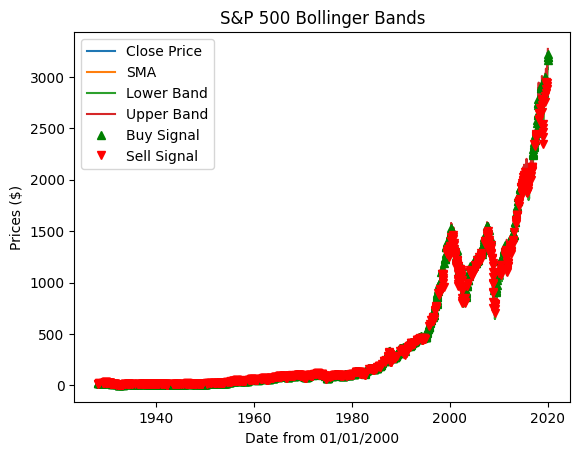

In [ ]:
new_df = calculate_bb(df, 20, 2)
new_df = bb_signal(new_df)

# Plot signals with close price and bands
min_day = 0
max_day = len(new_df.index)
x = range(min_day, max_day)
close = new_df["close"][min_day:max_day]
sma = new_df["sma"][min_day:max_day]
lower_band = new_df["lower_band"][min_day:max_day]
upper_band = new_df["upper_band"][min_day:max_day]

plt.plot(close, label="Close Price")
plt.plot(sma, label="SMA")
plt.plot(lower_band, label="Lower Band")
plt.plot(upper_band, label="Upper Band")

buy_signals = new_df[min_day:max_day][new_df["bb_signal"] == 1]
sell_signals = new_df[min_day:max_day][new_df["bb_signal"] == -1]

plt.plot(buy_signals["close"], "g^", label="Buy Signal")
plt.plot(sell_signals["close"], "rv", label="Sell Signal")
plt.xlabel("Date from 01/01/2000")
plt.ylabel("Prices ($)")
plt.title("S&P 500 Bollinger Bands")
plt.legend()
plt.show()

##Calculate total returns for the period
Trading rule:
* Start with the earliest buy signal, subtract the current price to the total
* Hold until the earliest sell signal, add the current price to the total
* Repeat until the end of period
* Add the current price at the end of the period to the total if the last signal before the end of the period that is not hold is a buy signal

In [ ]:
def bb(df, days, multiplier):
    new_df = calculate_bb(df, days, multiplier)
    new_df = bb_signal(new_df)
    new_df['bb_signal'] = new_df['bb_signal'].ffill()
    new_df['bb_returns'] = new_df['bb_signal'].shift(1) * new_df['log_returns']
    new_df['cumulative_bb_returns'] = (1 + new_df['bb_returns']).cumprod()
    return new_df

4.234494428564384


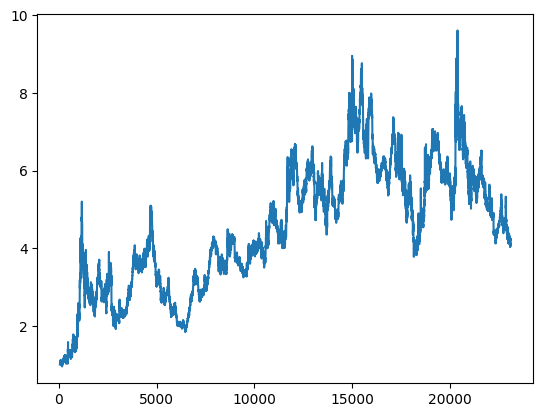

In [ ]:
new_df = bb(df, 50, 2)

print(new_df['cumulative_bb_returns'].iloc[-1])
plot_any(new_df['cumulative_bb_returns'])

##Result
The strategy does not seem to yield consistent positive returns over time, as the plot shows a back-and-forth movement rather than a clear upward trend. We should adjust the parameters: day of moving average and multiplier of standard deviation.

Now, make the parameters adjustable.

In [ ]:
# Create hyperparameter tuning vector for the parameters
days_list = [10, 15, 20, 30, 50]
multiplier_list = [1.5, 2, 2.5, 3]

n_model = 100
days_vec = np.random.choice(days_list, n_model)
multiplier_vec = np.random.choice(multiplier_list, n_model)

8 4.234494428564384
50 2.0


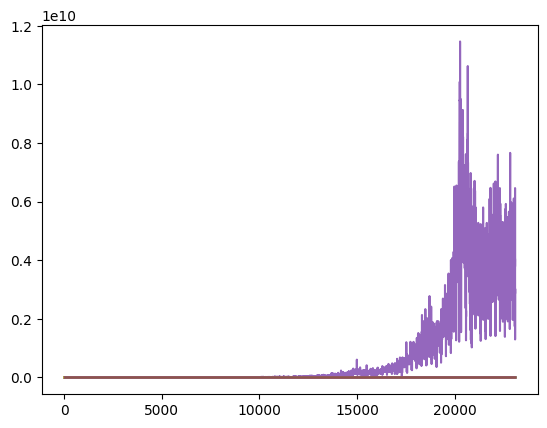

In [ ]:
# Find the best model
model_return = []
for i in range(n_model):
    new_df = bb(df, days_vec[i], multiplier_vec[i])
    model_return.append(new_df['cumulative_bb_returns'].iloc[-1])
    # print(i, model_return[i])

model_return = np.array(model_return)
model_return = model_return[~np.isnan(model_return)]

best_model_index = np.argmax(model_return)
print(best_model_index, model_return[best_model_index])
print(days_vec[best_model_index], multiplier_vec[best_model_index])

# Plot best model
plot_any(bb(df, days_vec[best_model_index], multiplier_vec[best_model_index]))

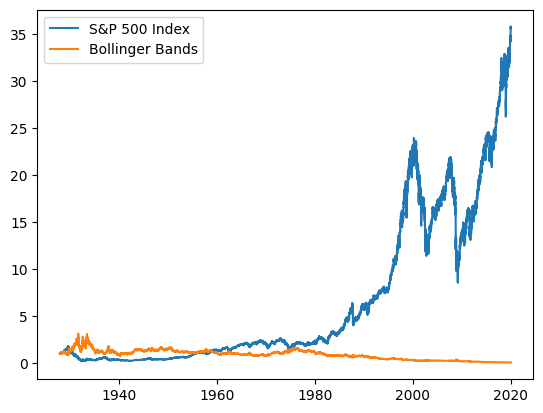

In [ ]:
plt.plot(new_df['cumulative_log_returns'], label="S&P 500 Index")
plt.plot(new_df['cumulative_bb_returns'], label="Bollinger Bands")
plt.legend()
plt.show()

##Conclusion
The best model uses 50-days simple moving average and 2 times multiplier for the standard deviation. We can see that there is a significant improvement in the returns. However, the new result can still be improved with a new strategy.

Now, we can try a new strategy: **RSI**.

#RSI

In [ ]:
def calculate_rsi(df, period):
    new_df = df.copy()
    delta = new_df["close"].diff(1) # find the differences
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean() # calculate average gains over period-day
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean() # calculate average losses over period-day
    rs = gain / loss # calculate gain over loss
    new_df["rsi"] = 100 - (100 / (1 + rs)) # calculate RSI
    return new_df

In [ ]:
new_df = calculate_rsi(df, 14)
new_df.head()

Price,close,high,low,open,volume,normal_returns,cumulative_normal_returns,log_returns,cumulative_log_returns,rsi
Date,,,,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0,NaN,NaN,NaN,NaN,NaN
1928-01-03,17.760000,17.760000,17.760000,17.760000,0,0.005663,1.005663,0.005647,1.005647,NaN
1928-01-04,17.719999,17.719999,17.719999,17.719999,0,-0.002252,1.003397,-0.002255,1.003379,NaN
1928-01-05,17.549999,17.549999,17.549999,17.549999,0,-0.009594,0.993771,-0.009640,0.993706,NaN
1928-01-06,17.660000,17.660000,17.660000,17.660000,0,0.006268,1.000000,0.006248,0.999915,NaN


##Interpretation
when RSI is below 30, it may be oversold; when RSI is above 70, the asset may be overbought.

In [ ]:
def rsi_signal(df, limits):
    new_df = df.copy()
    new_df["rsi_signal"] = new_df.apply(
        lambda row: 1 if row["rsi"] < limits[0]
        else -1 if row["rsi"] > limits[1]
        else np.nan,
        axis=1
    )
    return new_df

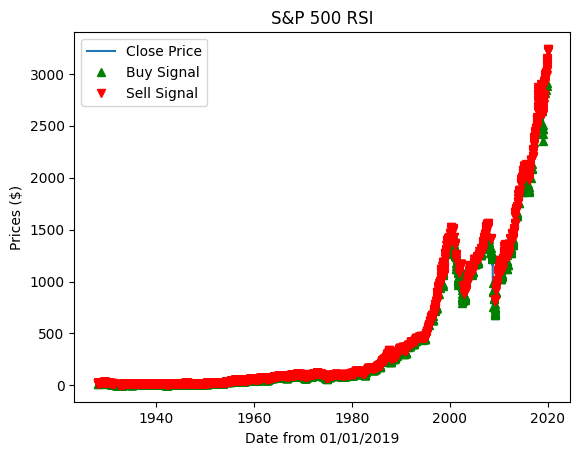

In [ ]:
new_df = calculate_rsi(df, 14)
new_df = rsi_signal(new_df, (30, 70))

# Plot signals with close price
min_day = 0
max_day = len(new_df.index)
close = new_df["close"][min_day:max_day]

plt.plot(close, label="Close Price")

buy_signals = new_df[min_day:max_day][new_df["rsi_signal"] == 1]
sell_signals = new_df[min_day:max_day][new_df["rsi_signal"] == -1]

plt.plot(buy_signals["close"], "g^", label="Buy Signal")
plt.plot(sell_signals["close"], "rv", label="Sell Signal")
plt.xlabel("Date from 01/01/2019")
plt.ylabel("Prices ($)")
plt.title("S&P 500 RSI")
plt.legend()
plt.show()

##Calculate total returns for the period
Trading rule:
* Start with the earliest buy signal, subtract the current price to the total
* Hold until the earliest sell signal, add the current price to the total
* Repeat until the end of period
* Add the current price at the end of the period to the total if the last signal before the end of the period that is not hold is a buy signal

In [ ]:
def rsi(df, period, limits):
    new_df = calculate_rsi(df, period)
    new_df = rsi_signal(new_df, limits)
    new_df['rsi_signal'] = new_df['rsi_signal'].ffill()
    new_df['rsi_returns'] = new_df['rsi_signal'].shift(1) * new_df['log_returns']
    new_df['cumulative_rsi_returns'] = (1 + new_df['rsi_returns']).cumprod()
    return new_df

0.20653700105886413


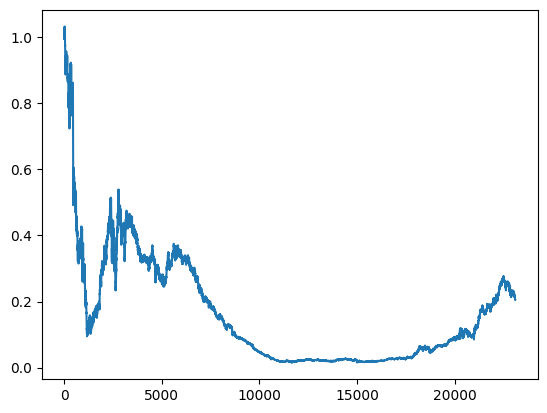

In [ ]:
new_df = rsi(df, 7, (40, 60))

print(new_df['cumulative_rsi_returns'].iloc[-1])
plot_any(new_df['cumulative_rsi_returns'])

##Result
The strategy does not seem to yield consistent positive returns over time, as the plot shows a back-and-forth movement rather than a clear upward trend. We should adjust the parameters: period that average gains and losses are over, overbought and oversold limits.

Now, make the parameters adjustable.

In [ ]:
# Create hyperparameter tuning vector for the parameters
period_list = [5, 7, 9, 14, 20, 21, 30]
limits_list = [(20, 80), (30, 70), (40, 60)]

n_model = 100
period_vec = np.random.choice(period_list, n_model)
indices = np.random.choice(len(limits_list), n_model)
limits_vec = [limits_list[i] for i in indices]

0 0.20653700105886413
7 (40, 60)


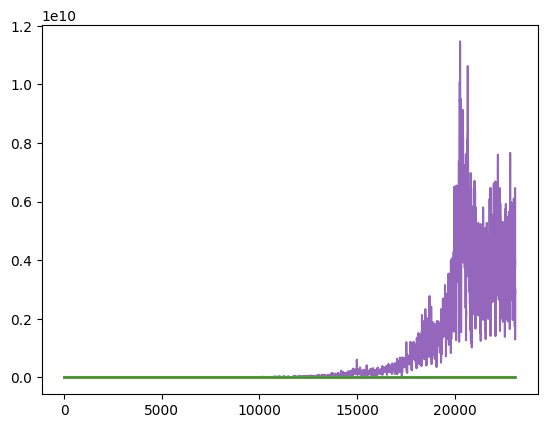

In [ ]:
# Find the best model
model_return = []
for i in range(n_model):
    new_df = rsi(df, period_vec[i], limits_vec[i])
    model_return.append(new_df['cumulative_rsi_returns'].iloc[-1])
    # print(i, model_return[i])

model_return = np.array(model_return)
model_return = model_return[~np.isnan(model_return)]

best_model_index = np.argmax(model_return)
print(best_model_index, model_return[best_model_index])
print(period_vec[best_model_index], limits_vec[best_model_index])

# Plot best model
plot_any(rsi(df, period_vec[best_model_index], limits_vec[best_model_index]))

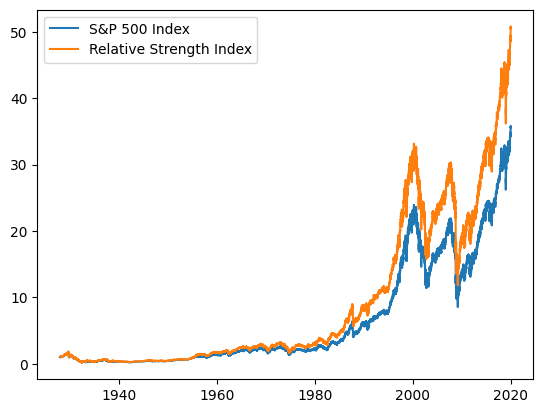

In [ ]:
plt.plot(new_df['cumulative_log_returns'], label="S&P 500 Index")
plt.plot(new_df['cumulative_rsi_returns'], label="Relative Strength Index")
plt.legend()
plt.show()

##Conclusion
The best model uses 30-days period and 30, 70 oversold and overbought limits. We can see that there is a significant improvement in the returns. However, the new result can still be improved with combining the two strategies.

Now, we can try combining the two strategies.

#Bollinger Bands + RSI
Use the functions that calculates the Bollinger Bands and the RSI, and create a new signal.

In [ ]:
def bb_rsi_signal(limits):
    df["bb_rsi_signal"] = df.apply(
        lambda row:"Sell" if row["rsi"] > limits[1] and row["close"] > row["upper_band"]
        else "Buy" if row["rsi"] < limits[0] and row["close"] < row["lower_band"]
        else "Hold" if pd.notna(row["rsi"]) and pd.notna(row["upper_band"]) and pd.notna(row["lower_band"])
        else np.nan,  # Set NaN if bands or rsi are not available
        axis=1
    )

In [ ]:
def get_bb_rsi_total(days, multiplier, period, limits):
    calculate_bb(days, multiplier)
    calculate_rsi(period)
    bb_rsi_signal(limits)
    total = [0 for i in range(df.shape[0])]
    hold = False
    for i in range(1, df.shape[0]):
        total[i] = total[i - 1]
        if not hold:
            if df["bb_rsi_signal"][i] == "Buy":
                total[i] -= df["close"][i]
                hold = True
        else:
            if df["bb_rsi_signal"][i] == "Sell":
                total[i] += df["close"][i]
                hold = False

    if hold:
        total[df.shape[0] - 1] += df["close"][df.shape[0] - 1]

    return total

In [ ]:
# Create hyperparameter tuning vector for the parameters
days_list = [10, 15, 20, 30, 50]
multiplier_list = [1.5, 2, 2.5, 3]
period_list = [5, 7, 9, 14, 20, 21, 30]
limits_list = [(20, 80), (30, 70), (40, 60)]

n_model = 2000
days_vec = np.random.choice(days_list, n_model)
multiplier_vec = np.random.choice(multiplier_list, n_model)
period_vec = np.random.choice(period_list, n_model)
indices = np.random.choice(len(limits_list), n_model)
limits_vec = [limits_list[i] for i in indices]

# n_model = 1
# days_vec = [10]
# multiplier_vec = [2]
# period_vec = [30]
# limits_vec = [(30, 70)]

In [ ]:
# Find the best model
model_total = [0 for i in range(n_model)]
for i in range(n_model):
    model_total[i] = get_bb_rsi_total(days_vec[i], multiplier_vec[i], period_vec[i], limits_vec[i])[-1]
    # print(i, model_total[i])

best_model_index = np.argmax(model_total)
print(best_model_index, model_total[best_model_index])
print(days_vec[best_model_index], multiplier_vec[best_model_index], period_vec[best_model_index], limits_vec[best_model_index])

# Plot best model
plot_any(get_bb_rsi_total(days_vec[best_model_index], multiplier_vec[best_model_index], period_vec[best_model_index], limits_vec[best_model_index]))

##Conclusion
The best model uses 50-days simple moving average with 2 times the standard deviation for the lower bound and upper bound, and 30-day period for the RSI with 30 oversold and 70 overbought limits. We can see that there is a significant improvement in the returns. However, we can consider be another strategy that can be added.

Now, we can try a new strategy: **MACD**.

#MACD

In [ ]:
def calculate_macd(short_period, long_period, signal_period):
    df["short_ema"] = df["close"].ewm(span=short_period, adjust=False).mean() # calculate short-term EMA
    df["long_ema"] = df["close"].ewm(span=long_period, adjust=False).mean() # calculate long-term EMA
    df["macd"] = df["short_ema"] - df["long_ema"] # calculate MACD
    df["signal_line"] = df["macd"].ewm(span=signal_period, adjust=False).mean() # calculate signal line
    df["histogram"] = df["macd"] - df["signal_line"] # calculate histogram (optional)

In [ ]:
calculate_macd(12, 26, 9)
df.head()

##Interpretation
When the MACD line is above the signal line, it is a bullish crossover, when the MACD line is below the signal line, it is a bearish crossover. Check the line for current day and previous day.

In [ ]:
# def macd_signal():
#     df["macd_signal"] = 0  # Initialize the signal column

#     for i in range(1, df.shape[0]):
#         # Bullish crossover: MACD crosses above Signal line
#         if df.loc[i, "macd"] > df.loc[i, "signal_line"] and df.loc[i - 1, "macd"] <= df.loc[i - 1, "signal_line"]:
#             df.loc[i, "macd_signal"] = "Buy"  # Buy signal
#         # Bearish crossover: MACD crosses below Signal line
#         elif df.loc[i, "macd"] < df.loc[i, "signal_line"] and df.loc[i - 1, "macd"] >= df.loc[i - 1, "signal_line"]:
#             df.loc[i, "macd_signal"] = "Sell"  # Sell signal
#         # Hold, otherwise
#         else:
#             df.loc[i, "macd_signal"] = "Hold"

def macd_signal():
    # Shift the macd and signal_line columns to get the previous row values
    df["macd_prev"] = df["macd"].shift(1)
    df["signal_line_prev"] = df["signal_line"].shift(1)

    df["macd_signal"] = df.apply(
        lambda row: "Buy" if row["macd"] > row["signal_line"] and row["macd_prev"] <= row["signal_line_prev"] # Bullish crossover: MACD crosses above Signal line
        else "Sell" if row["macd"] < row["signal_line"] and row["macd_prev"] >= row["signal_line_prev"] # Bearish crossover: MACD crosses below Signal line
        else "Hold" if pd.notna(row["macd"]) and pd.notna(row["signal_line"]) # Hold, otherwise
        else np.nan,  # Set NaN if macd or signal_line is not available
        axis=1
    )

    # Drop the temporary columns if they are no longer needed
    df.drop(columns=["macd_prev", "signal_line_prev"], inplace=True)


In [ ]:
macd_signal()

# Plot signals with close price
min_day = 0
max_day = len(df.index)
close = df["close"][min_day:max_day]

plt.plot(close, label="Close Price")

buy_signals = df[min_day:max_day][df["macd_signal"] == "Buy"]
sell_signals = df[min_day:max_day][df["macd_signal"] == "Sell"]

plt.plot(buy_signals["close"], "g^", label="Buy Signal")
plt.plot(sell_signals["close"], "rv", label="Sell Signal")
plt.xlabel("Date from 01/01/2019")
plt.ylabel("Prices ($)")
plt.title("S&P 500 MACD")
plt.legend()
plt.show()

##Calculate total returns for the period
Trading rule:
* Start with the earliest buy signal, subtract the current price to the total
* Hold until the earliest sell signal, add the current price to the total
* Repeat until the end of period
* Add the current price at the end of the period to the total if the last signal before the end of the period that is not hold is a buy signal

In [ ]:
def get_macd_total(short_period, long_period, signal_period):
    calculate_macd(short_period, long_period, signal_period)
    macd_signal()
    total = [0 for i in range(df.shape[0])]
    hold = False
    for i in range(1, df.shape[0]):
        total[i] = total[i - 1]
        if not hold:
            if df["macd_signal"][i] == "Buy":
                total[i] -= df["close"][i]
                hold = True
        else:
            if df["macd_signal"][i] == "Sell":
                total[i] += df["close"][i]
                hold = False

    if hold:
        total[df.shape[0] - 1] += df["close"][df.shape[0] - 1]

    return total

In [ ]:
total = get_macd_total(4, 30, 6)

print(total[df.shape[0] - 1])
plot_any(total)

##Result
The strategy does not seem to yield consistent positive returns over time, as the plot shows a back-and-forth movement rather than a clear upward trend. We should adjust the parameters: short period, long period, and signal period.

Now, make the parameters adjustable.

In [ ]:
# Create hyperparameter tuning vector for the parameters
short_period_list = [4, 8, 12, 15, 18]
long_period_list = [20, 23, 26, 30, 35, 39, 50]
signal_period_list = [4, 6, 9, 12, 15]

n_model = 500
short_period_vec = np.random.choice(short_period_list, n_model)
long_period_vec = np.random.choice(long_period_list, n_model)
signal_period_vec = np.random.choice(signal_period_list, n_model)

In [ ]:
# Find the best model
model_total = [0 for i in range(n_model)]
for i in range(n_model):
    model_total[i] = get_macd_total(short_period_vec[i], long_period_vec[i], signal_period_vec[i])[-1]
    # print(i, model_total[i])

best_model_index = np.argmax(model_total)
print(best_model_index, model_total[best_model_index])
print(short_period_vec[best_model_index], long_period_vec[best_model_index], signal_period_vec[best_model_index])

# Plot best model
plot_any(get_macd_total(short_period_vec[best_model_index], long_period_vec[best_model_index], signal_period_vec[best_model_index]))

##Conclusion
The best model uses 18 days for short period exponential moving average, 20 days for long period exponential moving average, and 6 days for signal period exponential moving average. We can see that there is a significant improvement in the returns. However, the new result can still be improved with combining the three strategies.

Now, we can try combining the three strategies.

#Bollinger Bands + RSI + MACD
Use the functions that calculates the Bollinger Bands, the RSI, and the MACD, and create a new signal.

In [ ]:
# def bb_rsi_macd_signal(limits):
#     # Shift the macd and signal_line columns to get the previous row values
#     df["macd_prev"] = df["macd"].shift(1)
#     df["signal_line_prev"] = df["signal_line"].shift(1)

#     df["bb_rsi_macd_signal"] = df.apply(
#         lambda row:"Sell" if row["macd"] < row["signal_line"] and row["macd_prev"] >= row["signal_line_prev"] and row["rsi"] > limits[1] and row["close"] > row["upper_band"]
#         else "Buy" if row["macd"] > row["signal_line"] and row["macd_prev"] <= row["signal_line_prev"] and row["rsi"] < limits[0] and row["close"] < row["lower_band"]
#         else "Hold" if pd.notna(row["macd"]) and pd.notna(row["signal_line"]) and pd.notna(row["rsi"]) and pd.notna(row["upper_band"]) and pd.notna(row["lower_band"])
#         else np.nan,  # Set NaN if bands or rsi are not available
#         axis=1
#     )

#     # Drop the temporary columns if they are no longer needed
#     df.drop(columns=["macd_prev", "signal_line_prev"], inplace=True)

def combined_signals(limits):
    df["bb_rsi_macd_signal"] = 0  # Initialize signal column

    for i in range(31, df.shape[0]):
        # NaN
        if (not pd.notna(df["macd"][i]) or not pd.notna(df["signal_line"][i]) or not pd.notna(df["rsi"][i]) or not pd.notna(df["upper_band"][i]) or not pd.notna(df["lower_band"][i])):
            df["bb_rsi_macd_signal"][i] = "NaN" # NaN signal

        # Buy Signal
        elif (df["close"][i] < df["lower_band"][i] and
            df["rsi"][i] < limits[0] and
            df["macd"][i] > df["signal_line"][i] and
            df["histogram"][i] > 0):
            df["bb_rsi_macd_signal"][i] = "Buy"  # Buy signal

        # Sell Signal
        elif (df["close"].iloc[i] > df["upper_band"].iloc[i] and
              df["rsi"].iloc[i] > limits[1] and
              df["macd"].iloc[i] < df["signal_line"].iloc[i] and
              df["histogram"].iloc[i] < 0):
            df["bb_rsi_macd_signal"][i] = "Sell"  # Sell signal

        # Hold
        elif (pd.notna(df["macd"][i]) and pd.notna(df["signal_line"][i]) and pd.notna(df["rsi"][i]) and pd.notna(df["upper_band"][i]) and pd.notna(df["lower_band"][i])):
            df["bb_rsi_macd_signal"][i] = "Hold" # Hold signal

In [ ]:
def get_bb_rsi_macd_total(days, multiplier, period, limits, short_period, long_period, signal_period):
    calculate_bb(days, multiplier)
    calculate_rsi(period)
    calculate_macd(short_period, long_period, signal_period)
    # bb_rsi_macd_signal(limits)
    combined_signals(limits)
    total = [0 for i in range(df.shape[0])]
    hold = False
    for i in range(1, df.shape[0]):
        total[i] = total[i - 1]
        if not hold:
            if df["bb_rsi_macd_signal"][i] == "Buy":
                total[i] -= df["close"][i]
                hold = True
        else:
            if df["bb_rsi_macd_signal"][i] == "Sell":
                total[i] += df["close"][i]
                hold = False

    if hold:
        total[df.shape[0] - 1] += df["close"][df.shape[0] - 1]

    return total

In [ ]:
# Create hyperparameter tuning vector for the parameters
days_list = [10, 15, 20, 30, 50]
multiplier_list = [1.5, 2, 2.5, 3]
period_list = [5, 7, 9, 14, 20, 21, 30]
limits_list = [(20, 80), (30, 70), (40, 60)]
short_period_list = [4, 8, 12, 15, 18]
long_period_list = [20, 23, 26, 30, 35, 39, 50]
signal_period_list = [4, 6, 9, 12, 15]

n_model = 1000
days_vec = np.random.choice(days_list, n_model)
multiplier_vec = np.random.choice(multiplier_list, n_model)
period_vec = np.random.choice(period_list, n_model)
indices = np.random.choice(len(limits_list), n_model)
limits_vec = [limits_list[i] for i in indices]
short_period_vec = np.random.choice(short_period_list, n_model)
long_period_vec = np.random.choice(long_period_list, n_model)
signal_period_vec = np.random.choice(signal_period_list, n_model)

# n_model = 1
# days_vec = [15]
# multiplier_vec = [2]
# period_vec = [7]
# limits_vec = [(30, 70)]
# short_period_vec = [15]
# long_period_vec = [20]
# signal_period_vec = [12]

In [ ]:
# Find the best model
model_total = [0 for i in range(n_model)]
for i in range(n_model):
    model_total[i] = get_bb_rsi_macd_total(days_vec[i], multiplier_vec[i], period_vec[i], limits_vec[i], short_period_vec[i], long_period_vec[i], signal_period_vec[i])[-1]
    print(i, model_total[i])

best_model_index = np.argmax(model_total)
print(best_model_index, model_total[best_model_index])
print(days_vec[best_model_index], multiplier_vec[best_model_index], period_vec[best_model_index], limits_vec[best_model_index], short_period_vec[best_model_index], long_period_vec[best_model_index], signal_period_vec[best_model_index])

# Plot best model
plot_any(get_bb_rsi_macd_total(days_vec[best_model_index], multiplier_vec[best_model_index], period_vec[best_model_index], limits_vec[best_model_index], short_period_vec[best_model_index], long_period_vec[best_model_index], signal_period_vec[best_model_index]))

##Conclusion
The best model uses 12 days for short period exponential moving average, 20 days for long period exponential moving average, and 15 days for signal period exponential moving average, with 15-days simple moving average with 2 times the standard deviation for the lower bound and upper bound, and 7-day period for the RSI with 30 oversold and 70 overbought limits. We can see that there is a significant improvement in the returns.